# Exploratory analysis of univariate and compound events

In [1]:
from dask.distributed import Client,LocalCluster
from dask_jobqueue import PBSCluster

In [2]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '00:05:00'
cores = 2
memory = str(4 * cores) + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])
                     # python=os.environ["DASK_PYTHON"])

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.6.21.28:8787/status,
Dashboard: http://10.6.21.28:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.21.28:38327,Workers: 0
Dashboard: http://10.6.21.28:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
%reload_ext autoreload
%autoreload 2

In [8]:
import warnings

import xarray as xr
import numpy as np
from xhistogram.xarray import histogram

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'

In [9]:
import functions as fn

plt_params = fn.get_plot_params()
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Load masks

In [10]:
rez_mask = xr.open_dataset(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/rez_mask_era5_grid.nc'
).REZ

In [11]:
gccsa_mask = xr.open_dataset(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/gccsa_mask_era5_grid.nc'
).GCCSA

# Load energy source and demand data

In [12]:
years = range(1959, 2021)

Sources: daily wind, daily solar and monthly runoff

In [13]:
rez_100w = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/100w_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['100w'].compute()

In [14]:
rez_mssrd = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/mssrd_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['mssrd'].compute()

In [15]:
rez_ro = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/ro_era5_monthly-averaged_sfc_'+str(years[0])+'-'+str(years[-1])+'_REZ_region_mean.zarr',
    consolidated=True
)['ro'].compute()

Demand: daily temperature

In [16]:
city_t = xr.open_zarr(
    '/g/data/w42/dr6273/work/projects/Aus_energy/data/t2m_era5_daily_1400UTC_sfc_'+str(years[0])+'-'+str(years[-1])+'_GCCSA_region_mean.zarr',
    consolidated=True
)['t2m'].compute()

# Convert to Celsius
city_t = city_t - 273.15

# How often to regional means exceed operational thresholds?

- For wind, we use 4 m/s (Ridder report)
- For solar, use 170 W/m^2 (Prasad 2021), or 95 W/m^2 (calculated from 342 kJ/hr in Ridder report using https://www.unitconverters.net/power/kilojoule-hour-to-watt.htm)
- For hydro, use 20th percentile of annual total runoff by region (made up)

- For temperature demand, we use a lower limit of 15 C and an upper limit of 21 C. From here: https://www.energyrating.gov.au/sites/default/files/documents/Climate_zone_mapping_-_air_con_FINAL_title_updated_0.pdf

In [17]:
def get_events(da, thresh, tail='lower'):
    if tail == 'lower':
        return xr.where(da < thresh, 1, 0)
    elif tail == 'upper':
        return xr.where(da > thresh, 1, 0)
    else:
        raise ValueError('Incorrect string for tail')

In [18]:
def calculate_event_frequency(da, thresh,
                              tail, time_name='time'):
    T = len(da[time_name].values)
    events = get_events(da, thresh, tail)
    freq = events.sum(time_name) / T
            
    return freq

In [19]:
def get_event_years(da, thresh, tail='lower', time_name='time'):
    """
    Get the event years and other years of da.
    """
    if tail == 'lower':
        event_years = da.where(
            da < thresh
        ).dropna(time_name)[time_name].dt.year.values

        other_years = da.where(
            da >= thresh
        ).dropna(time_name)[time_name].dt.year.values
    elif tail == 'upper':
        event_years = da.where(
            da > thresh
        ).dropna(time_name)[time_name].dt.year.values

        other_years = da.where(
            da <= thresh
        ).dropna(time_name)[time_name].dt.year.values
    
    return event_years, other_years

In [20]:
def freq_drought_compare(daily_events,
                         ann_da, thresh_ann_da,
                         tail='lower', time_name='time'):
    """
    Calculate frequency of daily events (i.e. days surpassing some threshold)
    on drought years (years below some threshold), and
    on all other years. Output is two dataarrays.
    
    daily_da: xarray dataarray of daily data
    thresh_daily_da: int, float or da. Threshold to define daily events.
    drought_da: xarray dataarray of annual data (typically runoff or precip)
    thresh_drought_da: int, float or da. Threshold to define drought events.
    tail: string, 'lower' (default) or 'upper'. Whether daily events are
        defined as below or above the threshold.
    """
    def freq_during_years(da, years, time_name):
        """
        Frequency of events on given years.
        """
        subset_da = da.sel(
            time=da[time_name].dt.year.isin(years)
        )
        counts = subset_da.sum(time_name)
        
        return counts / len(subset_da[time_name].values)
                                
    # We need to do it separately for each region because different times
    #  may be dropped (different drought years across regions).
    drought_da_list = []
    other_da_list = []
    for i, region in enumerate(daily_events.region.values):
        # Get drought and other years
        drought_years, other_years = get_event_years(
            ann_da.sel(region=region),
            thresh_ann_da.sel(region=region),
            tail,
            time_name
        )
        
        # Frequency during drought and other years
        r_events = daily_events.sel(region=region)
        
        freq_during_drought = freq_during_years(r_events,
                                                drought_years,
                                                time_name)
        freq_during_other = freq_during_years(r_events,
                                              other_years,
                                              time_name)
        
        drought_da_list.append(freq_during_drought)
        other_da_list.append(freq_during_other)
        
    drought_da = xr.concat(drought_da_list, dim='region')
    other_da = xr.concat(other_da_list, dim='region')
    
    return drought_da, other_da

In [21]:
def get_regions_from_region_codes(region_codes):
    regions = [rez_mask.region.values[i] for i in range(len(rez_mask.region.values)) if
               rez_mask.region_code.values[i] in region_codes]
    return regions

In [294]:
def plot_freq(ax, da, title, mask, region_codes=None, vmin_vmax_interval='auto'):

    regions = da.region
    if isinstance(region_codes, list):
        regions = get_regions_from_region_codes(region_codes)
    da = xr.where(mask.sel(region=regions),
                  da.sel(region=regions),
                  np.nan)
    da = da.sum('region', skipna=True)
    plot_da = da.where(mask.sel(region=regions).sum('region'))
    
    # Get data and colorbar limits
    if vmin_vmax_interval == 'auto':
        da_max = plot_da.max().values
        da_min = plot_da.min().values
        
        if da_min >= 0: # For positive data, this will lie 0-1
            cmap = 'viridis'
            vmin = 0
            if da_max > 0.2:
                vmax = fn.round_decimals_up(da_max, 1)
                cbar_tick_intervals = 0.1
            elif da_max > 0.05:
                vmax = fn.round_decimals_up(da_max, 2)
                cbar_tick_intervals = 0.01
            else:
                vmax = fn.round_decimals_up(da_max, 3)
                cbar_tick_intervals = 0.001
        else: # Symmetric data
            cmap = 'RdBu_r'
            abs_max = np.max([np.abs(da_min), da_max])
            if abs_max > 0.2:
                vmax = fn.round_decimals_up(abs_max, 1)
                cbar_tick_intervals = 0.1
            elif abs_max > 0.1:
                vmax = fn.round_decimals_up(abs_max, 2)
                cbar_tick_intervals = 0.01
            else:
                vmax = fn.round_decimals_up(abs_max, 2)
                cbar_tick_intervals = 0.01
            vmin = -vmax
                
    elif isinstance(vmin_vmax_interval, list):
        cmap = 'viridis'
        vmin = vmin_vmax_interval[0]
        vmax = vmin_vmax_interval[1]
        cbar_tick_intervals = vmin_vmax_interval[2]
    else:
        raise ValueError("vmin_vmax_interval should be 'auto' or list with the \
        first element the desired vmin, and the second element vmax.")
                
    with plt.rc_context(plt_params):
        # ax.coastlines()
        ax.add_feature(
            cartopy.feature.NaturalEarthFeature(category='cultural',
                                                name='admin_1_states_provinces',
                                                scale='10m'),
            facecolor='none', edgecolor='k', lw=plt_params['lines.linewidth'] / 3
        )

        p = plot_da.plot(ax=ax, cmap=cmap, vmin=vmin, vmax=vmax, add_colorbar=False)
        
        # Colorbar
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        axins = inset_axes(ax, width="10%", height="100%",
                           bbox_to_anchor=(1.03, .01, .5, .99),
                           bbox_transform=ax.transAxes, loc='lower left', borderpad=0)
        cb1 = matplotlib.colorbar.ColorbarBase(ax=axins, cmap=cmap, norm=norm,
                                               ticks=np.arange(vmin, vmax+cbar_tick_intervals, cbar_tick_intervals),
                                               orientation='vertical')
        ax.set_title(title)

In [23]:
rez_ro_ann = rez_ro.resample(time='1YS').sum()

In [24]:
thresh_100w = 4
thresh_mssrd = 170
thresh_ro = rez_ro_ann.quantile(0.2, 'time')
thresh_t_cool = 15
thresh_t_warm = 21

### Frequencies of univariate events

In [25]:
freq_100w = calculate_event_frequency(rez_100w, thresh_100w, tail='lower')

In [26]:
freq_mssrd = calculate_event_frequency(rez_mssrd, thresh_mssrd, tail='lower')

In [27]:
freq_ro = calculate_event_frequency(rez_ro_ann, thresh_ro, tail='lower')

In [28]:
freq_t_upp = calculate_event_frequency(city_t, thresh_t_warm, tail='upper')

In [29]:
freq_t_low = calculate_event_frequency(city_t, thresh_t_cool, tail='lower')

### Frequencies of compound wind and solar lulls

In [30]:
freq_100w_mssrd = xr.where(
    (rez_100w < thresh_100w) &
    (rez_mssrd < thresh_mssrd),
    1, 0
).sum('time') / len(rez_100w.time.values)

### Solar and/or wind lulls compounding with hydropower droughts

We show the difference in relative frequency between wind/solar/compound lulls on drought years and all other years (drought - other).

Only REZs with hydro are shown, because the drought years are specific to each REZ.

Wind during drought

In [31]:
events_100w = get_events(rez_100w, thresh_100w, tail='lower')

freq_drought_100w, freq_other_100w = freq_drought_compare(
    events_100w, rez_ro_ann, thresh_ro, tail='lower'
)

Solar during drought

In [32]:
events_mssrd = get_events(rez_mssrd, thresh_mssrd, tail='lower')

freq_drought_mssrd, freq_other_mssrd = freq_drought_compare(
    events_mssrd, rez_ro_ann, thresh_ro, tail='lower'
)

Wind and solar during drought

In [33]:
events_100w_mssrd = xr.where(
    (rez_100w < thresh_100w) &
    (rez_mssrd < thresh_mssrd),
    1, 0
)
# We want this array to have a var name, so we convert to dataset, name and select
events_100w_mssrd = events_100w_mssrd.to_dataset(name='compound')
events_100w_mssrd = events_100w_mssrd['compound']

freq_drought_100w_mssrd, freq_other_100w_mssrd = freq_drought_compare(
    events_100w_mssrd, rez_ro_ann, thresh_ro, tail='lower'
)

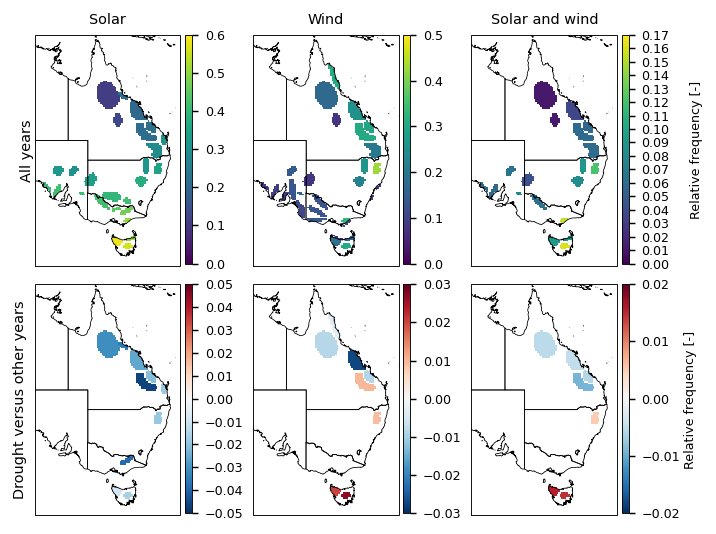

In [295]:
with plt.rc_context(plt_params):
    fig = plt.figure(1, dpi=130)

    ax1 = plt.subplot(231, projection=ccrs.PlateCarree())
    ax2 = plt.subplot(232, projection=ccrs.PlateCarree())
    ax3 = plt.subplot(233, projection=ccrs.PlateCarree())
    ax4 = plt.subplot(234, projection=ccrs.PlateCarree())
    ax5 = plt.subplot(235, projection=ccrs.PlateCarree())
    ax6 = plt.subplot(236, projection=ccrs.PlateCarree())
    
    plot_freq(ax1, freq_mssrd, 'Solar', mask=rez_mask, region_codes=[2, 3, 6, 7])
    plot_freq(ax2, freq_100w, 'Wind', mask=rez_mask, region_codes=[1, 3, 5, 7])
    plot_freq(ax3, freq_100w_mssrd, 'Solar and wind', mask=rez_mask, region_codes=[3, 7])
    plot_freq(ax4, freq_drought_mssrd - freq_other_mssrd,
              '', mask=rez_mask, region_codes=[6, 7])
    plot_freq(ax5, freq_drought_100w - freq_other_100w,
              '', mask=rez_mask, region_codes=[5, 7])
    plot_freq(ax6, freq_drought_100w_mssrd - freq_other_100w_mssrd,
              '', mask=rez_mask, region_codes=[7])
    
    ax1.text(-0.1, 0.5, 'All years', rotation=90, fontsize=plt_params['axes.titlesize'],
             transform=ax1.transAxes, va='center', ha='left')
    ax4.text(-0.1, 0.5, 'Drought versus other years', rotation=90, fontsize=plt_params['axes.titlesize'],
             transform=ax4.transAxes, va='center', ha='center')
    
    ax3.text(1.5, 0.5, 'Relative frequency [-]', rotation=90, fontsize=plt_params['font.size'],
             transform=ax3.transAxes, va='center', ha='left')
    ax6.text(1.5, 0.5, 'Relative frequency [-]', rotation=90, fontsize=plt_params['font.size'],
             transform=ax6.transAxes, va='center', ha='center')
    
    plt.subplots_adjust(hspace=0.08, wspace=0.05)

# How often do these lulls occur simultaneously across regions?

### Daily events by region

In [34]:
def to_dayofyear(ds):
    """
    Reshapes array from time to year and dayofyear. Leap year days are manually
    removed, and days after this are reassigned as if there was no leap year.
    So dayofyear is always 1-365.
    
    From: https://github.com/pydata/xarray/discussions/5119#discussioncomment-581232
    """
    from itertools import cycle
    
    year = ds.time.dt.year
    day = ds.time.dt.dayofyear

    # assign new coords
    ds = ds.assign_coords(
        year=("time", year.data),
        dayofyear=("time", day.data)
    )

    # reshape the array to (..., "month", "year")
    return ds.set_index(
        time=("year", "dayofyear")
    ).unstack("time") 

Remove leap year days (29/02) so we have equal row lengths

In [35]:
w100_2d = to_dayofyear(events_100w.convert_calendar('noleap'))
mssrd_2d = to_dayofyear(events_mssrd.convert_calendar('noleap'))

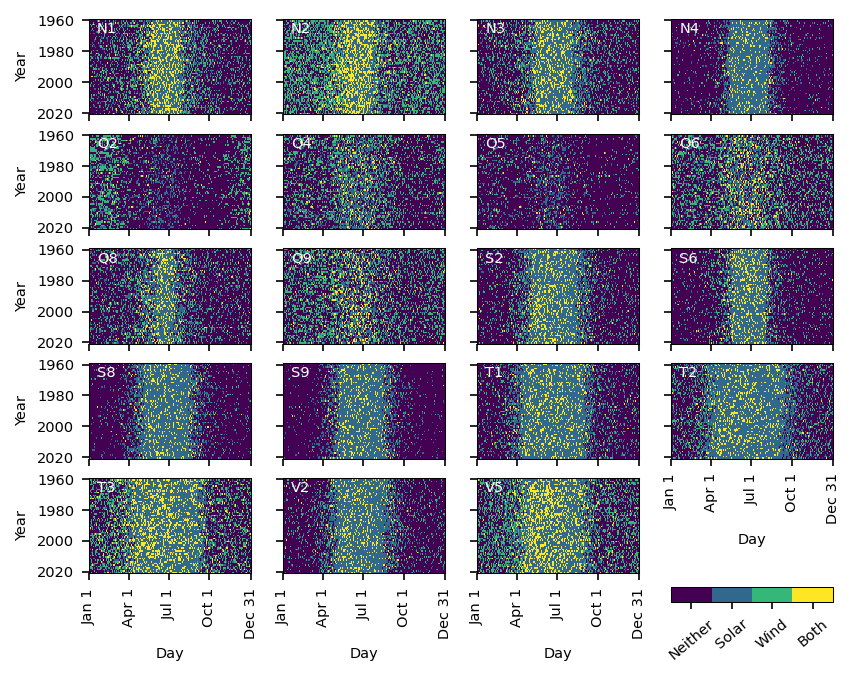

In [78]:
regions = get_regions_from_region_codes([3, 7])
d = mssrd_2d + w100_2d * 2

cmap = matplotlib.cm.get_cmap('viridis')
cmapBig = matplotlib.cm.get_cmap('viridis', 512)
cmap_max = 512
cbar_max = 4.5
newcmap = matplotlib.colors.ListedColormap(cmapBig(np.linspace(0, 1, cmap_max//2)))
norm = matplotlib.colors.BoundaryNorm(np.arange(cbar_max + 0.5), newcmap.N)

with plt.rc_context(plt_params):
    fig, ax = plt.subplots(5, 4, dpi=150)
    
    for i, region in enumerate(regions):
        # d.sel(region=region).plot(ax=ax.flatten()[i],
        #                           add_colorbar=False)
        p = ax.flatten()[i].pcolormesh(
            d.sel(region=region).data,
            cmap=cmap, norm=norm
        )
        ax.flatten()[i].set_ylim(ax.flatten()[i].get_ylim()[::-1])
        
        ax.flatten()[i].set_title('')
        ax.flatten()[i].text(0.05, 0.85, region,
                             c='w', transform=ax.flatten()[i].transAxes)
        
        if i in [0, 4, 8, 12, 16]:
            ax.flatten()[i].set_ylabel('Year')
            ax.flatten()[i].set_yticks(range(1, 81, 20))
            ax.flatten()[i].set_yticklabels(range(1960, 2021, 20))
        else:
            ax.flatten()[i].set_ylabel('')
            ax.flatten()[i].set_yticks(range(1, 81, 20))
            ax.flatten()[i].set_yticklabels('')
            
        if i > 14:
            ax.flatten()[i].set_xlabel('Day')
            ax.flatten()[i].set_xticks([0, 90, 181, 272, 365])
            ax.flatten()[i].set_xticklabels(['Jan 1', 'Apr 1', 'Jul 1', 'Oct 1', 'Dec 31'],
                                           rotation=90)
        else:
            ax.flatten()[i].set_xlabel('')
            ax.flatten()[i].set_xticks([0, 90, 181, 272, 365])
            ax.flatten()[i].set_xticklabels('')
            
    ax.flatten()[-1].axis('off')
    
    axins1 = inset_axes(ax.flatten()[-1], width="200%", height="20%",
                        bbox_to_anchor=(.5, -0.3, .5, .8),
                        bbox_transform=ax.flatten()[-1].transAxes, loc='lower right', borderpad=0)
    cb1 = fig.colorbar(p, cax=axins1, orientation='horizontal', ticks=np.arange(0.5, cbar_max, 1))
    cb1.ax.minorticks_off()
    cb1.ax.set_xticklabels(['Neither', 'Solar', 'Wind', 'Both'], rotation=40)

### Daily events over all regions

In [36]:
# Simultaneous wind/solar/compound lulls over all years
simul_100w = events_100w.sel(region=get_regions_from_region_codes([1, 3, 5, 7])).sum('region')
simul_mssrd = events_mssrd.sel(region=get_regions_from_region_codes([2, 3, 6, 7])).sum('region')
simul_100w_mssrd = events_100w_mssrd.sel(region=get_regions_from_region_codes([3, 7])).sum('region')

In [60]:
# Months in seasons
season_dict = {
        'Annual': range(1, 13),
        'Winter': [6, 7, 8],
        'Spring': [9, 10, 11],
        'Summer': [12, 1, 2],
        'Autumn': [3, 4, 5]
    }

In [37]:
def hist_data(da):
    bins = np.linspace(0, da.max().values, da.max().values + 1)
    h = histogram(da, bins=[bins], density=True)
    h = h.rename({list(h.coords)[0]: 'bin'})
    return h['bin'], h

In [169]:
def month_subset(da, months, time_name='time'):
    return da.isel({time_name: da.time.dt.month.isin(months)})

In [177]:
def hist_plot(ax, da, months, color, label,
              fill_alpha=0.3, xlim=30, time_name='time'):
    subset_da = month_subset(da, months, time_name)
    bins, hist = hist_data(subset_da)
    
    ax.plot(bins, hist, color=color, label=label)
    ax.fill_between(bins, 0, hist, color=color, alpha=fill_alpha)
    
    ymax = fn.round_decimals_up(hist.max().values, 1)
    ax.set_ylim(0, ymax)
    ax.set_yticks(np.arange(0, ymax+0.01, 0.1))
    
    ax.set_xlim(0, xlim)
    ax.set_xticks(np.arange(0, xlim, 5))
    
    return hist

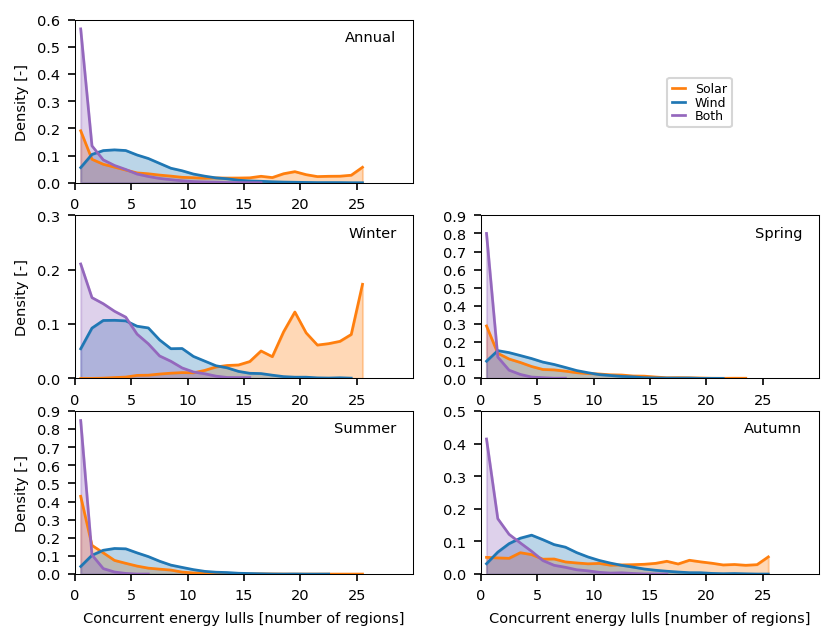

In [182]:
with plt.rc_context(plt_params):
    fig = plt.figure(1, dpi=150)
    
    ax1 = fig.add_subplot(321)
    ax2 = fig.add_subplot(323)
    ax3 = fig.add_subplot(324)
    ax4 = fig.add_subplot(325)
    ax5 = fig.add_subplot(326)
    axes = [ax1, ax2, ax3, ax4, ax5]
    
    for (ax, months, title) in zip(axes, season_dict.values(), season_dict.keys()):
    
        p1 = hist_plot(ax, simul_mssrd, months, colors[1], 'Solar')
        p2 = hist_plot(ax, simul_100w, months, colors[0], 'Wind')
        p3 = hist_plot(ax, simul_100w_mssrd, months, colors[4], 'Both')
        
        ymax = np.max([p1.max(), p2.max(), p3.max()])
        ax.set_ylim(0, fn.round_decimals_up(ymax, 1))
        ax.text(0.95, 0.85, title, transform=ax.transAxes, ha='right', va='bottom')
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc=(0.8, 0.8))
    
    for ax in [ax1, ax2, ax4]:
        ax.set_ylabel('Density [-]')
    for ax in [ax4, ax5]:
        ax.set_xlabel('Concurrent energy lulls [number of regions]')

### Daily events on drought vs non-drought years

In [252]:
def simul_during_drought(n_droughts, thresh_n_droughts,
                         daily_events, region_codes,
                         time_name='time'):
    drought_years, other_years = get_event_years(
        n_droughts,
        thresh_n_droughts,
        'upper'
    )
    
    subset_drought = daily_events.sel({
        'region': get_regions_from_region_codes(region_codes),
        time_name: daily_events[time_name].dt.year.isin(drought_years)
    }).sum('region')
    
    subset_other = daily_events.sel({
        'region': get_regions_from_region_codes(region_codes),
        time_name: daily_events[time_name].dt.year.isin(other_years)
    }).sum('region')
    
    return subset_drought, subset_other

In [257]:
def ks_pval(da1, da2, months):
    from scipy.stats import ks_2samp
    subset_da1 = month_subset(da1, months).values
    subset_da2 = month_subset(da2, months).values
    return ks_2samp(subset_da1, subset_da2)[-1]

In [258]:
def ad_pval(da1, da2, months):
    from scipy.stats import anderson_ksamp
    subset_da1 = month_subset(da1, months).values
    subset_da2 = month_subset(da2, months).values
    return anderson_ksamp([subset_da1, subset_da2])[-1]

In [272]:
def figure_dist_tests(ax, da1, da2, months):
    signif_tests = []
    
    ksp = ks_pval(da1, da2, months)
    if ksp < 0.05:
        signif_tests.append('KS')
        
    adp = ad_pval(da1, da2, months)
    if adp < 0.05:
        signif_tests.append('AD')
              
    ylocs = [[0.8, 0.6][i] for i in range(len(signif_tests))]
    if len(ylocs) > 0:
        for i in range(len(ylocs)):
            ax.text(0.92, ylocs[i], signif_tests[i], ha='center', transform=ax.transAxes)

In [278]:
ro_hydro = rez_ro_ann.sel(region=get_regions_from_region_codes([5, 6, 7]))
n_simul_droughts = xr.where(ro_hydro < thresh_ro, 1, 0).sum('region')

In [287]:
thresh_n_droughts = 3 # Minimum number of hydro regions in drought

In [288]:
simul_ro_100w_drought, simul_ro_100w_other = simul_during_drought(
    n_simul_droughts,
    thresh_n_droughts,
    events_100w, [1, 3, 5, 7]
)

In [289]:
simul_ro_mssrd_drought, simul_ro_mssrd_other = simul_during_drought(
    n_simul_droughts,
    thresh_n_droughts,
    events_mssrd, [2, 3, 6, 7]
)

In [290]:
simul_ro_100w_mssrd_drought, simul_ro_100w_mssrd_other = simul_during_drought(
    n_simul_droughts,
    thresh_n_droughts,
    events_100w_mssrd, [3, 7]
)

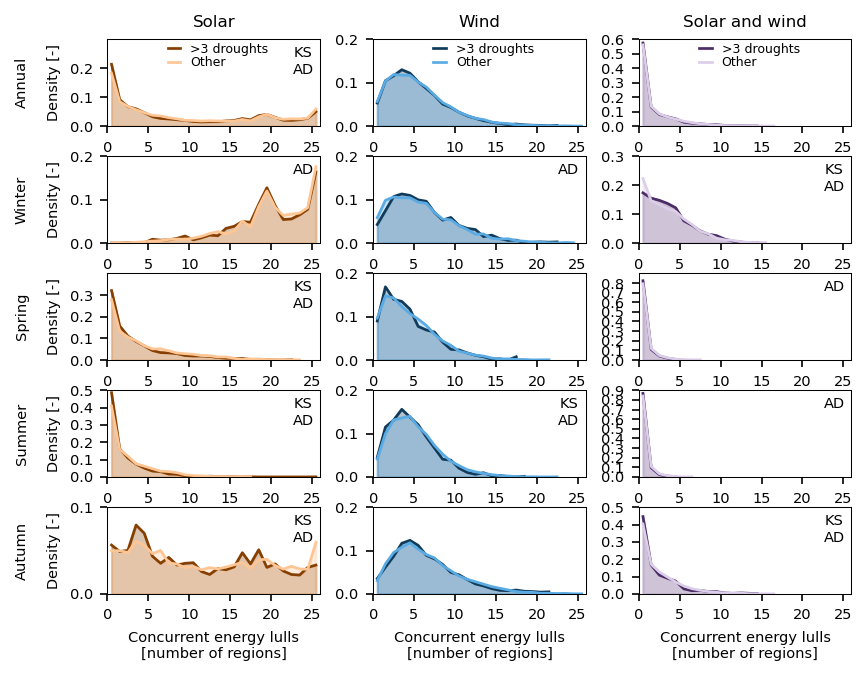

In [293]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    xlim=26
    drought_legend_label = '>'+str(thresh_n_droughts)+' droughts'

    with plt.rc_context(plt_params):
        fig = plt.figure(1, dpi=150)

        axes = []
        for i in range(15):
            axes.append(fig.add_subplot(5, 3, i+1))

        plot_colors = [colors[1], colors[0], colors[4]]

        for i, (months, title) in enumerate(zip(season_dict.values(), season_dict.keys())):

            p1 = hist_plot(axes[i*3], simul_ro_mssrd_drought, months, fn.adjust_lightness(colors[1], 0.5), drought_legend_label, xlim=xlim)
            p2 = hist_plot(axes[i*3], simul_ro_mssrd_other, months, fn.adjust_lightness(colors[1], 1.5), 'Other', xlim=xlim)

            figure_dist_tests(axes[i*3], simul_ro_mssrd_drought, simul_ro_mssrd_other, months)

            ymax = np.max([p1.max(), p2.max()])
            axes[i*3].set_ylim(0, fn.round_decimals_up(ymax, 1))

            p1 = hist_plot(axes[i*3+1], simul_ro_100w_drought, months, fn.adjust_lightness(colors[0], 0.5), drought_legend_label, xlim=xlim)
            p2 = hist_plot(axes[i*3+1], simul_ro_100w_other, months, fn.adjust_lightness(colors[0], 1.5), 'Other', xlim=xlim)

            figure_dist_tests(axes[i*3+1], simul_ro_100w_drought, simul_ro_100w_other, months)

            ymax = np.max([p1.max(), p2.max()])
            axes[i*3+1].set_ylim(0, fn.round_decimals_up(ymax, 1))

            p1 = hist_plot(axes[i*3+2], simul_ro_100w_mssrd_drought, months, fn.adjust_lightness(colors[4], 0.5), drought_legend_label, xlim=xlim)
            p2 = hist_plot(axes[i*3+2], simul_ro_100w_mssrd_other, months, fn.adjust_lightness(colors[4], 1.5), 'Other', xlim=xlim)

            figure_dist_tests(axes[i*3+2], simul_ro_100w_mssrd_drought, simul_ro_100w_mssrd_other, months)

            ymax = np.max([p1.max(), p2.max()])
            axes[i*3+2].set_ylim(0, fn.round_decimals_up(ymax, 1))

        for ax in axes[:3]:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, loc=(0.26, 0.6), frameon=False)

        for ax, title in zip([axes[i] for i in [0, 3, 6, 9, 12]], season_dict.keys()):
            ax.set_ylabel(title+'\n\nDensity [-]')
        for ax in axes[-3:]:
            ax.set_xlabel('Concurrent energy lulls\n[number of regions]')

        axes[0].set_title('Solar')
        axes[1].set_title('Wind')
        axes[2].set_title('Solar and wind')
        
        plt.subplots_adjust(hspace=0.35, wspace=0.25)

# Close cluster

In [52]:
client.close()
cluster.close()